In [6]:
# Wikipedia2vec stuff:
from wikipedia2vec import Wikipedia2Vec
wiki2vec = Wikipedia2Vec.load("models/enwiki_20180420_win10_100d.pkl")

In [1]:
import wikipedia
from tqdm import tqdm
import decimal

In [2]:
rwanda = wikipedia.page("Rwanda", auto_suggest=False)

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# read in DHS survey cluster loc data
rwanda_clusters_loc =  pd.read_csv("data/Rwanda/rwanda_clusters_location.csv")
rwanda_clusters_loc = rwanda_clusters_loc[['DHSCLUST', 'LATNUM', 'LONGNUM']] # columns required
rwanda_clusters_loc.columns = ['cluster', 'latitude', 'longitude'] # rename required columns

# read survey data
data_hh = pd.read_stata('data/Rwanda/Rwanda-DHS-2010/RW_2010_DHS_02192021_2229_158318/RWHR61DT/RWHR61FL.DTA') # takes a while
data_hh_names = list(data_hh.columns) # read in DHS survey data for wealth index factor
wealth_by_clust = data_hh.groupby('hv001').mean() # get mean of all variables by cluster ID
wealth_by_clust.index = range(0, 492) # set index properly
wealth_by_clust['hv001'] = range(1, 493) # fix cluster ID variable

# use non-normalized wealth score to match with the provided results
wealth_by_clust['hv271_decimal'] = wealth_by_clust['hv271']/100000  # divide by 100000 to match with the 5-decimal provided form
wealth_by_clust = wealth_by_clust[['hv001', 'hv271_decimal']] # keep required columns
wealth_by_clust.columns = ['cluster', 'cluster_wealth_mean'] # rename columns


rwanda_cluster_avg_asset_2010 = rwanda_clusters_loc.merge(wealth_by_clust, # merge
                                                           left_on='cluster', right_on='cluster')
rwanda_cluster_avg_asset_2010.to_csv('data/Rwanda/outputs/rwanda_cluster_avg_asset_2010.csv', index=False) # write to disk
rwanda_cluster_avg_asset_2010.head(5)

,cluster,latitude,longitude,cluster_wealth_mean
0,1.0,-2.532818,29.684726,-0.386620
1,2.0,-1.833858,30.310689,-0.421574
2,3.0,-1.888155,29.478298,-0.449724
3,4.0,-2.366763,30.521692,-0.390006
4,5.0,-2.171266,30.018541,-0.416924


In [24]:
def get_all_articles_near_clust(clust, already_obtained={}, 
                                keep_content=False, get_embeddings=False, model_funct=None):
    '''
    Function for getting all of the wikipedia articles near a given cluster 
    (within a radius of 10 km)
    '''
    lat = clust['latitude']
    lng = clust['longitude']
    article_titles = wikipedia.geosearch(lat, lng, results=1000, radius=10000)
    article_titles += wikipedia.geosearch(lat, lng, results=1000, radius=10000)
    pages_info = {}
    for article_title in article_titles[:1]:
        if article_title not in already_obtained:
            page = wikipedia.page(article_title, auto_suggest=False)
            print(page)
            pages_info[page.title]={'latitude' : page.coordinates[0], 
                                     'longitude': page.coordinates[1]}
            if keep_content:
                pages_info[page.title]['text'] = page.content
            
            if get_embeddings:
                pages_info[page.title]['embedding'] = model_funct(page.title)
    return pages_info

### Rwanda

In [25]:
wiki_articles = {}
for i in tqdm(range(1)):#len(rwanda_cluster_avg_asset_2010))):
    wiki_articles.update(get_all_articles_near_clust(rwanda_cluster_avg_asset_2010.iloc[i], 
                                                     wiki_articles, 
                                                     keep_content=True, get_embeddings=True, 
                                                     model_funct=wiki2vec.get_entity_vector))

  0%|          | 0/1 [00:00<?, ?it/s]

<WikipediaPage 'Maraba, Rwanda'>


  0%|          | 0/1 [00:01<?, ?it/s]


KeyError: 

In [15]:
article_df = pd.DataFrame(wiki_articles).T

In [13]:
article_df.head()

,latitude,longitude
"Maraba, Rwanda",-2.5158000000000000362376795237651094794273376...,29.6844000000000001193711796076968312263488769...
Huye District,-2.5166666700000002165893420169595628976821899...,29.6999999999999992894572642398998141288757324...
Mount Huye,-2.5666666700000000389536580769345164299011230...,29.6499999999999985789145284797996282577514648...
Butare Airport,-2.5950000000000001953992523340275511145591735...,29.7399999999999984368059813277795910835266113...
Stade Huye,-2.5961111099999998330645212263334542512893676...,29.7419444400000010375606507295742630958557128...


In [156]:
# # Plot just articles 


# rwanda_cluster_avg_asset_2010 = pd.read_csv('data/Rwanda/outputs/rwanda_cluster_avg_asset_2010.csv')
# rwa_adm2 = gpd.read_file('data/Rwanda/gadm36_RWA_shp/gadm36_RWA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# # plot
# fig, ax = plt.subplots(figsize=(10, 10))
# plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
# ax.scatter(article_df['longitude'], article_df['latitude'],
#                   c='green', s=11) # plot survey clusters
# ax.spines['left'].set_visible(False) # hide all axes
# ax.spines['bottom'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
# ax.set_title('Geolocated Wikipedia Articles Near DHS Clusters')
# plt.savefig('Rwanda_Wiki_Articles.png')
# plt.show()

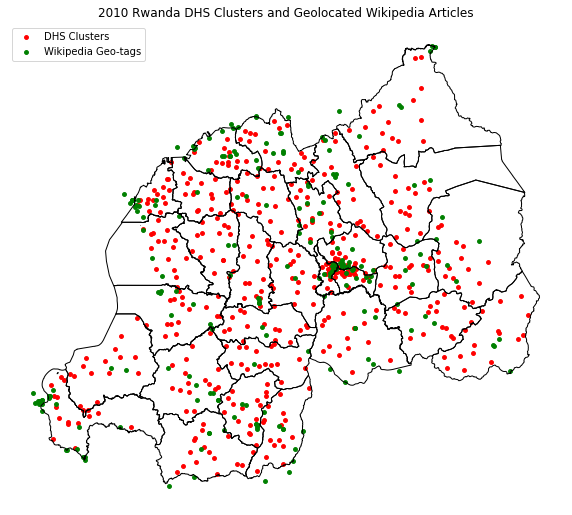

In [163]:
# Plot articles and clsuters

rwanda_cluster_avg_asset_2010 = pd.read_csv('data/Rwanda/outputs/rwanda_cluster_avg_asset_2010.csv')
rwa_adm2 = gpd.read_file('data/Rwanda/gadm36_RWA_shp/gadm36_RWA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(rwanda_cluster_avg_asset_2010['longitude'], 
                  rwanda_cluster_avg_asset_2010['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(article_df['longitude'], article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2010 Rwanda DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Rwanda_Wiki_Articles_and_2010_DHS_Clusts.png')
plt.show()

In [157]:
# ## plot cluster locations on a map of Rwanda -----

# from mpl_toolkits.axes_grid1 import make_axes_locatable # for color map

# rwanda_cluster_avg_asset_2010 = pd.read_csv('data/Rwanda/outputs/rwanda_cluster_avg_asset_2010.csv')
# rwa_adm2 = gpd.read_file('data/Rwanda/gadm36_RWA_shp/gadm36_RWA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# # plot
# fig, ax = plt.subplots(figsize=(10, 10))
# plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
# plot = ax.scatter(rwanda_cluster_avg_asset_2010['longitude'], rwanda_cluster_avg_asset_2010['latitude'],
#                   c=rwanda_cluster_avg_asset_2010['cluster_wealth_mean'], cmap='RdBu', s=11) # plot survey clusters
# ax.scatter(article_df['longitude'], article_df['latitude'],
#                   c='green', s=11) # plot survey clusters
# ax.spines['left'].set_visible(False) # hide all axes
# ax.spines['bottom'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
# cax = divider.append_axes("right", size="3%")
# cbar = fig.colorbar(plot, ax=ax, cax=cax)
# cbar.ax.set_ylabel('Avg cluster wealth', rotation=270)
# ax.set_title('2010 Rwanda DHS Clusters by Wealth and Geolocated Wikipedia Articles')
# plt.savefig('Rwanda_Wiki_Articles_and_2010_DHS_Clusts_Wealth.png')
# plt.show()

In [36]:
rwanda_cluster_avg_asset_2010

,cluster,latitude,longitude,cluster_wealth_mean
0,1.0,-2.532818,29.684726,-0.386620
1,2.0,-1.833858,30.310689,-0.421574
2,3.0,-1.888155,29.478298,-0.449724
3,4.0,-2.366763,30.521692,-0.390006
4,5.0,-2.171266,30.018541,-0.416924
...,...,...,...,...
487,488.0,-2.389778,29.451722,-0.490285
488,489.0,-2.144317,30.348895,-0.387647
489,490.0,-1.967830,30.441541,0.451675
490,491.0,-1.441294,30.063765,-0.217502


In [97]:
!ls

data  Figs  models  Proposal  Untitled.ipynb


In [190]:
dhs_clusts.head()

,country,year,lat,lon,wealthpooled,households,urban_rural
0,angola,2011,-12.350257,13.534922,2.595618,36,1
1,angola,2011,-12.360865,13.551494,2.209620,32,1
2,angola,2011,-12.613421,13.413085,0.906469,36,1
3,angola,2011,-12.581454,13.397711,1.105359,35,1
4,angola,2011,-12.578135,13.418748,1.879344,37,1


In [98]:
dhs_clusts = pd.read_csv('data/dhs_clusters.csv')

### Ghana

In [114]:
ghana_clusts = dhs_clusts[(dhs_clusts['country']== 'ghana') & (dhs_clusts['year']== 2014)]

In [119]:
ghana_clusts = ghana_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [120]:
gh_wiki_articles = {}
for i in tqdm(range(len(ghana_clusts))):
    gh_wiki_articles.update(get_all_articles_near_clust(ghana_clusts.iloc[i], gh_wiki_articles))

100%|██████████| 422/422 [12:49<00:00,  1.82s/it] 


In [121]:
gh_article_df = pd.DataFrame(gh_wiki_articles).T

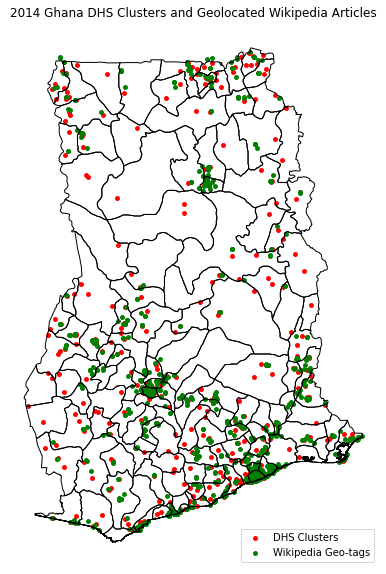

In [164]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Ghana/gadm36_GHA_shp/gadm36_GHA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(ghana_clusts['longitude'], ghana_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(gh_article_df['longitude'], gh_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2014 Ghana DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Ghana_Wiki_Articles_and_2014_DHS_Clusts.png')
plt.show()

### Uganda

In [132]:
uganda_clusts = dhs_clusts[(dhs_clusts['country']== 'uganda') & (dhs_clusts['year']== 2014)]
uganda_clusts = uganda_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [133]:
ug_wiki_articles = {}
for i in tqdm(range(len(uganda_clusts))):
    ug_wiki_articles.update(get_all_articles_near_clust(uganda_clusts.iloc[i], ug_wiki_articles))

100%|██████████| 208/208 [08:33<00:00,  2.47s/it] 


In [138]:
ug_article_df = pd.DataFrame(ug_wiki_articles).T

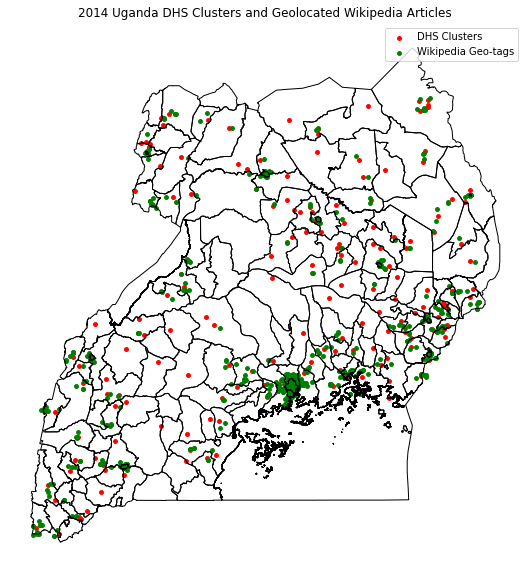

In [166]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Uganda/gadm36_UGA_shp/gadm36_UGA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(uganda_clusts['longitude'], uganda_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(ug_article_df['longitude'], ug_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2014 Uganda DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Uganda_Wiki_Articles_and_2014_DHS_Clusts.png')
plt.show()

### Nigeria

In [169]:
nigeria_clusts = dhs_clusts[(dhs_clusts['country']== 'nigeria') & (dhs_clusts['year']== 2010)]
nigeria_clusts = nigeria_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [170]:
nigeria_clusts

,country,year,latitude,longitude,wealthpooled,households,urban_rural
11956,nigeria,2010,6.732517,8.002321,-0.642530,26,0
11957,nigeria,2010,7.247508,8.657348,-0.406471,25,0
11958,nigeria,2010,7.358567,8.489307,-0.420117,26,0
11959,nigeria,2010,6.864353,8.890684,-0.654294,26,0
11960,nigeria,2010,6.950979,8.345339,0.256707,25,0
...,...,...,...,...,...,...,...
12190,nigeria,2010,7.383139,3.964110,1.085200,26,0
12191,nigeria,2010,7.385056,3.894900,0.775521,26,1
12192,nigeria,2010,7.407212,3.906515,1.492821,26,1
12193,nigeria,2010,8.127695,4.241894,0.629930,24,1


In [171]:
ng_wiki_articles = {}
for i in tqdm(range(len(nigeria_clusts))):
    ng_wiki_articles.update(get_all_articles_near_clust(nigeria_clusts.iloc[i], ng_wiki_articles))

100%|██████████| 239/239 [14:43<00:00,  3.70s/it] 


In [172]:
ng_article_df = pd.DataFrame(ng_wiki_articles).T

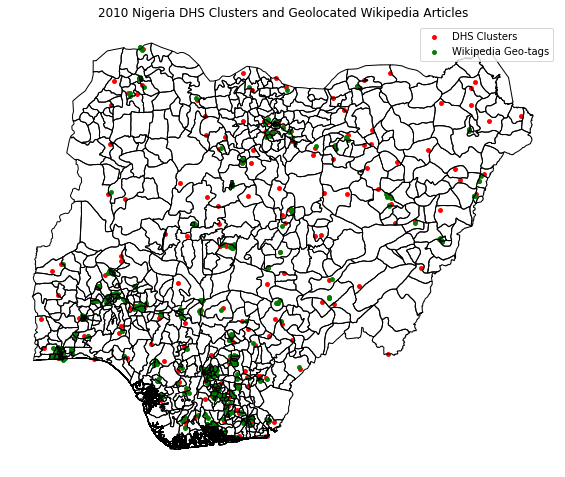

In [175]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Nigeria/gadm36_NGA_shp/gadm36_NGA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(nigeria_clusts['longitude'], nigeria_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(ng_article_df['longitude'], ng_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2010 Nigeria DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Nigeria_Wiki_Articles_and_2010_DHS_Clusts.png')
plt.show()

### Malawi

In [176]:
malawi_clusts = dhs_clusts[(dhs_clusts['country']== 'malawi') & (dhs_clusts['year']== 2014)]
malawi_clusts = malawi_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [177]:
malawi_clusts

,country,year,latitude,longitude,wealthpooled,households,urban_rural
9497,malawi,2014,-9.530501,33.243335,-0.612943,24,0
9498,malawi,2014,-9.823194,33.378386,-0.545313,25,0
9499,malawi,2014,-10.111930,33.559969,-0.380111,25,0
9500,malawi,2014,-9.720551,33.288311,0.697978,25,1
9501,malawi,2014,-9.700572,33.259847,-0.190441,24,1
...,...,...,...,...,...,...,...
9632,malawi,2014,-15.829764,35.088025,0.654036,23,1
9633,malawi,2014,-15.853695,35.092018,0.203208,24,1
9634,malawi,2014,-15.825565,35.017303,0.737767,25,1
9635,malawi,2014,-15.842032,34.986195,0.138676,25,1


In [178]:
mw_wiki_articles = {}
for i in tqdm(range(len(malawi_clusts))):
    mw_wiki_articles.update(get_all_articles_near_clust(malawi_clusts.iloc[i], mw_wiki_articles))

100%|██████████| 140/140 [03:00<00:00,  1.29s/it]


In [179]:
mw_article_df = pd.DataFrame(mw_wiki_articles).T

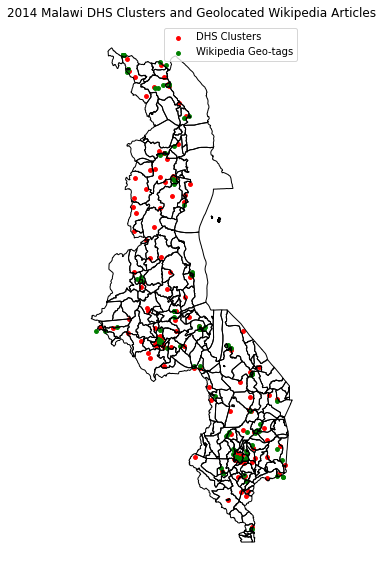

In [180]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Malawi/gadm36_MWI_shp/gadm36_MWI_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(malawi_clusts['longitude'], malawi_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(mw_article_df['longitude'], mw_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2014 Malawi DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Malawi_Wiki_Articles_and_2014_DHS_Clusts.png')
plt.show()

### Tanzania

In [183]:
tanzania_clusts = dhs_clusts[(dhs_clusts['country']== 'tanzania') & (dhs_clusts['year']== 2010)]
tanzania_clusts = tanzania_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [184]:
tanzania_clusts

,country,year,latitude,longitude,wealthpooled,households,urban_rural
15410,tanzania,2010,-6.138477,35.743701,0.176254,21,1
15411,tanzania,2010,-4.715211,36.007287,-0.612848,22,0
15412,tanzania,2010,-5.108290,36.301132,-0.548252,20,0
15413,tanzania,2010,-5.659221,35.389710,-1.144426,20,0
15414,tanzania,2010,-4.562516,35.756384,-0.746132,20,0
...,...,...,...,...,...,...,...
15863,tanzania,2010,-6.012883,39.220247,-0.206345,21,0
15864,tanzania,2010,-6.001724,39.246531,0.027277,22,0
15865,tanzania,2010,-5.928924,39.254502,-0.044876,22,0
15866,tanzania,2010,-5.985061,39.242211,-0.007156,22,0


In [185]:
tz_wiki_articles = {}
for i in tqdm(range(len(tanzania_clusts))):
    tz_wiki_articles.update(get_all_articles_near_clust(tanzania_clusts.iloc[i], tz_wiki_articles))

100%|██████████| 458/458 [13:06<00:00,  1.72s/it]  


In [186]:
tz_article_df = pd.DataFrame(tz_wiki_articles).T

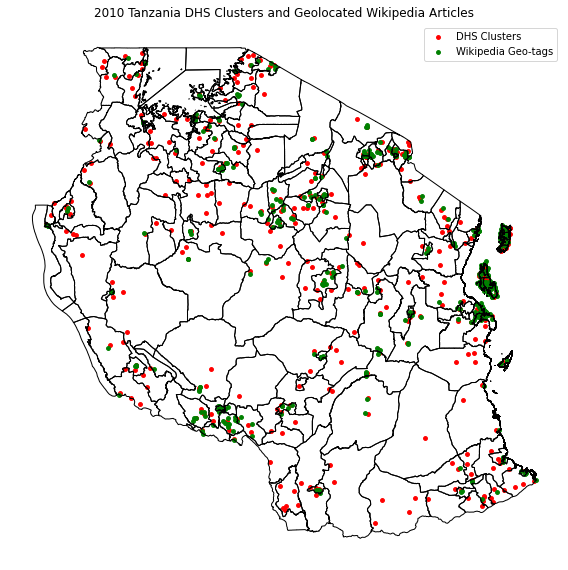

In [188]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Tanzania/gadm36_TZA_shp/gadm36_TZA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(tanzania_clusts['longitude'], tanzania_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(tz_article_df['longitude'], tz_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2010 Tanzania DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Tanzania_Wiki_Articles_and_2010_DHS_Clusts.png')
plt.show()

In [189]:
print(f"Num of Clusters and Articles")
print(f"Rwanda & {len(rwanda_cluster_avg_asset_2010)} & {len(wiki_articles)} \\\\")
print("\\hline")
print(f"Ghana & {len(ghana_clusts)} & {len(gh_wiki_articles)} \\\\")
print("\\hline")
print(f"Uganda & {len(uganda_clusts)} & {len(ug_wiki_articles)} \\\\")
print("\\hline")
print(f"Nigeria & {len(nigeria_clusts)} & {len(ng_wiki_articles)} \\\\")
print("\\hline")
print(f"Malawi & {len(malawi_clusts)} & {len(mw_wiki_articles)} \\\\")
print("\\hline")
print(f"Tanzania & {len(tanzania_clusts)} & {len(tz_wiki_articles)} \\\\")
print("\\hline")

Num of Clusters and Articles
Rwanda & 492 & 233 \\
\hline
Ghana & 422 & 906 \\
\hline
Uganda & 208 & 804 \\
\hline
Nigeria & 239 & 613 \\
\hline
Malawi & 140 & 125 \\
\hline
Tanzania & 458 & 573 \\
\hline
